<a href="https://colab.research.google.com/github/iamyumang/CustomerSuccessBox/blob/master/CustomerSuccessBox2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#import all the required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import random
import plotly.express as px
from imblearn.over_sampling import SMOTE
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 

from sklearn.model_selection import GridSearchCV 
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from sklearn.metrics import average_precision_score
import warnings
warnings.filterwarnings("ignore")

In [0]:
#uploading train and test file

train= pd.read_csv("https://raw.githubusercontent.com/iamyumang/CustomerSuccessBox/master/Train_Set.csv")     
test= pd.read_csv("https://raw.githubusercontent.com/iamyumang/CustomerSuccessBox/master/Test_Set.csv")

In [339]:
train.head()

,account_id,week_start_date,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,feature40,feature41,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50,feature51,feature52,feature53,feature54,feature55,feature56,feature57,feature58,feature59,feature60,feature61,feature62,Label
0,100559.0,2018-09-03,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,101026.0,2018-09-03,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,101026.0,2018-09-10,0.0,0.0,86.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,18.666667,0.0,3.000000,2.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.333333,0.0,0.0,0.666667,84.666667,0.0,0.0,0.0,0.0,0.0,7.000000,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,101026.0,2018-09-17,0.0,0.0,-0.076046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.067797,0.0,-0.250000,0.272727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.300000,0.0,0.0,-0.400000,-0.194553,0.0,0.0,0.0,0.0,0.0,-0.333333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,101026.0,2018-09-24,0.0,0.0,-0.987654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,-0.5,-0.952381,0.0,-0.666667,-0.785714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.571429,0.0,0.0,0.000000,-0.985507,0.0,0.0,0.0,0.0,0.0,-0.812500,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [340]:
#quick summary of train dataset
train.describe()

,account_id,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,feature40,feature41,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50,feature51,feature52,feature53,feature54,feature55,feature56,feature57,feature58,feature59,feature60,feature61,feature62,Label
count,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000,114706.000000
mean,130757.085715,0.003826,0.000253,1.220189,0.000076,0.000068,0.001619,0.011936,0.000265,0.027169,0.001554,0.000137,0.137495,0.000708,0.003593,0.002222,0.001467,0.000186,0.096916,0.666540,0.000106,0.117995,0.109916,0.015433,0.000639,0.000268,0.000558,0.012289,0.008324,0.000432,0.000541,0.000017,0.019243,0.002334,0.001391,0.000305,0.011709,0.000889,0.020907,0.006015,0.000095,0.006964,0.000027,0.039589,0.001578,0.000246,0.006456,1.353492,0.000553,0.011016,0.003317,0.000017,0.000579,0.370711,0.000612,0.042691,0.015129,0.000111,0.023753,0.002694,0.002593,0.001441,0.041088,0.009381
std,41252.322475,0.112332,0.042883,14.874235,0.013079,0.012731,0.099576,0.484970,0.026294,2.321826,0.091397,0.018222,1.116015,0.088242,0.243556,0.077602,0.070265,0.021556,0.877443,6.504554,0.014273,1.176290,2.881443,0.341076,0.037906,0.025202,0.041234,0.530597,0.192684,0.034618,0.044531,0.006658,0.455966,0.083133,0.060182,0.039150,0.395202,0.045984,0.380070,0.317354,0.014833,0.154442,0.007741,2.881298,0.146695,0.028173,0.190054,17.001162,0.039927,0.385185,0.120010,0.006163,0.057921,3.023755,0.106045,0.533951,0.772402,0.018222,0.749735,0.136656,0.125907,0.107580,1.737335,0.096398
min,100000.000000,-0.894737,-0.705882,-0.999442,-0.500000,-0.500000,-0.916667,-0.992701,-0.700000,-0.998079,-0.872093,-0.500000,-0.987500,-0.812500,-0.909091,-0.857143,-0.857143,-0.714286,-0.985612,-0.998792,-0.571429,-0.992126,-0.970588,-0.988166,-0.666667,-0.823529,-0.866667,-0.993548,-0.971429,-0.755102,-0.840909,-0.571429,-0.968254,-0.769231,-0.920000,-0.882353,-0.981884,-0.500000,-0.954545,-0.957447,-0.500000,-0.952381,-0.500000,-0.941176,-0.974359,-0.852941,-0.981481,-0.999341,-0.818182,-0.987500,-0.954545,-0.500000,-0.846154,-0.998485,-0.782609,-0.975000,-0.993750,-0.750000,-0.989455,-0.926471,-0.989691,-0.907514,-0.996314,0.000000
25%,101631.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,105252.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [341]:
train['week_start_date'] =  pd.to_datetime(train['week_start_date'])


#count of unique values of account and date
print(train['week_start_date'].nunique())
print(train["account_id"].nunique())

83
2690


In [342]:
#check duplicate rows
duplicateDFRow = train[train.duplicated()]
print(duplicateDFRow["Label"].value_counts())


0    21104
1      427
Name: Label, dtype: int64


In [0]:
#remove duplicates
train= train.drop_duplicates()
train.reset_index(drop= True, inplace= True)

Proportion: 142.567 : 1


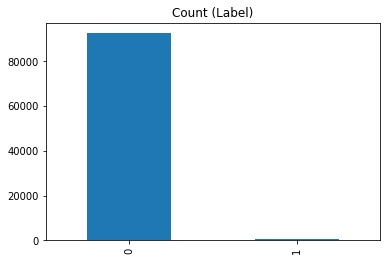

In [344]:
#ratio of non-event to event
label_count= train["Label"].value_counts()
print('Proportion:', round(label_count[0] / label_count[1], 4), ': 1')
label_count.plot(kind='bar', title='Count (Label)');

In [345]:
#checking counts of all columns unique values
col= train.columns
col= col[2:64]
for i in col:
    print(train[i].nunique())
col= col.tolist()

912
93
20425
17
12
256
1437
87
1243
411
11
7151
204
528
26
80
50
6374
16749
93
6508
6024
1576
255
116
141
1001
871
234
207
15
1683
783
528
72
1257
26
1278
970
19
1114
25
2957
194
102
713
22794
318
1283
544
43
163
13101
126
2999
717
32
2087
453
513
198
2214


In [346]:
#Sorting account_ids by their count in decreasing order
#100583 has maximum no. of count

train= train.set_index(['account_id','week_start_date']).sort_index()
train.reset_index(inplace= True)
train= train.iloc[train.groupby('account_id').account_id.transform('size').mul(-1).argsort(kind='mergesort')]
train.reset_index(drop= True, inplace= True)
train.head()

,account_id,week_start_date,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,feature40,feature41,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50,feature51,feature52,feature53,feature54,feature55,feature56,feature57,feature58,feature59,feature60,feature61,feature62,Label
0,100583.0,2018-09-03,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,100583.0,2018-09-10,0.0,0.0,80.300000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.600000,0.0,0.0,0.0,0.0,0.0,3.300000,29.600000,0.0,2.300000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.200000,0.0,0.500000,0.0,0.0,0.100000,73.500000,0.0,0.0,0.0,0.0,0.0,26.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,100583.0,2018-09-17,0.0,0.0,-0.166946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.269481,0.0,0.0,0.0,0.0,0.0,-0.492600,-0.337493,0.0,-0.118457,-0.318182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,-0.166667,0.0,-0.151515,0.0,0.0,-0.090909,-0.325198,0.0,0.0,0.0,0.0,0.0,-0.451178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,100583.0,2018-09-24,0.0,0.0,0.142819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.368889,0.0,0.0,0.0,0.0,0.0,0.191667,0.420628,0.0,0.375000,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.0,0.0,0.0,0.300000,0.0,-0.057143,0.0,0.0,0.000000,0.483906,0.0,0.0,0.0,0.0,0.0,0.180982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,100583.0,2018-10-01,0.0,0.0,-0.227677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.246032,0.0,0.0,0.0,0.0,0.0,-0.188034,-0.278549,0.0,-0.277778,-0.259259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.090909,0.0,0.0,0.0,-0.059829,0.0,-0.074074,0.0,0.0,0.000000,0.017277,0.0,0.0,0.0,0.0,0.0,-0.384127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [347]:
#Calculating the counts for each account_id and save them into another column i.e. "count"
account_id_count = train.groupby('account_id')['Label'].agg(['sum','count'])
account_id_count.reset_index(drop= False, inplace= True)
account_id_count.head()

,account_id,sum,count
0,100000.0,0,44
1,100001.0,0,12
2,100003.0,0,9
3,100004.0,2,89
4,100005.0,0,41


In [0]:
# Grouped all accounts by account_id with the sum of all other variables to find the number of events for each account
# For example: account_id 100000 has 44 counts and 0 events. account_id 100004 has 89 counts and 2 events(For better understanding, please check "Label" column).

train_grouped = train.groupby(["account_id"]).sum()
train_grouped.sort_values(by= "Label",ascending= True, inplace = True)
train_grouped.reset_index(drop= False, inplace= True)
train_grouped.sort_values(by= "account_id",ascending= True, inplace = True)
train_grouped.reset_index(drop= True, inplace= True)
train_grouped["count"]= account_id_count["count"]

In [349]:
train_grouped.head()

,account_id,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,feature40,feature41,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50,feature51,feature52,feature53,feature54,feature55,feature56,feature57,feature58,feature59,feature60,feature61,feature62,Label,count
0,100000.0,3.485053,1.158654,36.800554,0.0,0.0,21.419514,5.879839,1.382335,9.330304,2.078139,0.0,6.991696,1.212702,6.973500,0.000000,0.0,0.028684,2.701700,20.424384,0.057253,11.131898,29.448554,3.170007,0.079849,0.171388,0.396866,3.590984,0.250810,0.257764,2.607044,0.0,26.049360,6.350184,0.050680,0.043366,1.263757,0.000000,9.333098,0.139758,0.0,11.924060,0.0,16.633066,0.736657,1.140028,6.542342,20.300121,0.226660,5.912320,1.894648,0.048525,3.362513,16.105990,1.040594,3.686682,15.893577,0.049996,21.446294,2.773099,0.286947,1.014272,10.637811,0,44
1,100001.0,0.000000,0.000000,28.287567,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,6.552778,0.000000,0.000000,0.000000,0.0,0.000000,5.054712,18.946854,0.000000,3.312927,0.000000,0.144336,0.000000,0.000000,0.000000,0.000000,0.321429,0.000000,0.000000,0.0,0.000000,0.000000,0.027778,0.000000,0.065873,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.027778,0.000000,0.000000,0.000000,22.172289,0.000000,0.000000,0.000000,0.000000,0.000000,10.668715,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,12
2,100003.0,0.000000,0.000000,315.262168,0.0,0.0,0.000000,0.000000,0.000000,0.263204,0.005630,0.0,10.067573,0.004555,0.000641,0.000000,0.0,0.000000,10.100567,114.436096,0.001196,10.342487,6.618507,4.553334,0.001748,0.000000,0.000000,0.002924,0.001545,0.000000,0.000000,0.0,0.000000,0.000000,0.001035,0.000000,0.002428,0.000000,0.133955,4.573844,0.0,0.036723,0.0,3.456016,0.000000,0.000000,0.000641,199.097026,0.000000,0.000000,0.000000,0.000000,0.000000,59.668335,0.000000,17.725958,0.000000,0.000000,0.000000,0.000000,0.000641,0.000000,0.000000,0,9
3,100004.0,0.000000,0.000000,88.532561,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.037220,0.009091,0.000000,0.166667,0.0,0.000000,2.037220,10.753748,0.009091,0.061122,4.273388,0.473863,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.007576,0.000000,0.000000,0.166667,0.000000,0.000000,0.0,0.026587,0.0,1.563838,0.000000,0.000000,0.007576,37.911469,0.000000,0.000000,0.000000,0.000000,0.000000,15.840193,0.000000,0.551161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,89
4,100005.0,0.000000,0.000000,93.945983,0.0,0.0,0.159845,0.000000,0.000000,1.018779,1.007273,0.0,28.493056,0.004318,0.004180,0.000000,0.0,0.000000,20.235944,80.350090,0.000349,22.151375,23.903425,1.752347,0.008055,0.004961,0.000000,0.000840,0.067062,0.000000,0.000000,0.0,33.296201,1.920533,0.039980,0.000000,1.265070,0.000000,7.088805,0.355284,0.0,0.069117,0.0,7.426365,0.000000,0.000000,0.008444,73.105169,0.000363,24.121619,0.001299,0.000000,0.000000,31.353165,0.000000,25.166061,0.000000,0.000000,0.001895,2.063781,3.808821,0.000000,0.004517,0,41


In [350]:
train_grouped= train_grouped.sort_values(by= "Label", ascending= True)
train_grouped.reset_index(drop= True, inplace= True)
train_grouped.head()

,account_id,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,feature40,feature41,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50,feature51,feature52,feature53,feature54,feature55,feature56,feature57,feature58,feature59,feature60,feature61,feature62,Label,count
0,100000.0,3.485053,1.158654,36.800554,0.0,0.0,21.419514,5.879839,1.382335,9.330304,2.078139,0.0,6.991696,1.212702,6.9735,0.0,0.0,0.028684,2.701700,20.424384,0.057253,11.131898,29.448554,3.170007,0.079849,0.171388,0.396866,3.590984,0.25081,0.257764,2.607044,0.0,26.04936,6.350184,0.05068,0.043366,1.263757,0.0,9.333098,0.139758,0.0,11.92406,0.0,16.633066,0.736657,1.140028,6.542342,20.300121,0.22666,5.91232,1.894648,0.048525,3.362513,16.105990,1.040594,3.686682,15.893577,0.049996,21.446294,2.773099,0.286947,1.014272,10.637811,0,44
1,181476.0,0.000000,0.000000,9.271546,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.477381,0.000000,0.0000,0.0,0.0,0.000000,0.477381,2.354557,0.000000,1.869371,0.059524,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.083333,0.0,0.00000,0.0,0.017857,0.000000,0.000000,0.000000,6.705984,0.00000,0.00000,0.000000,0.000000,0.000000,1.537721,0.000000,4.760375,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,7
2,181559.0,0.000000,0.000000,181.285739,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,3.840079,0.000000,0.0000,0.0,0.0,0.000000,3.840079,31.120130,0.000000,7.723019,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,228.057345,0.00000,0.00000,0.000000,0.000000,0.000000,14.468879,0.000000,0.833333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,9
3,181605.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.083333,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,8
4,181783.0,0.000000,0.000000,6.831760,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,4.882350,0.000000,0.0000,0.0,0.0,0.000000,1.419048,8.592537,0.000000,9.868616,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.266667,0.000000,0.000000,0.000000,36.364868,0.00000,0.00000,0.000000,0.000000,0.000000,14.004846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,8


In [0]:
#Creating a list of account_ids which have only '0' in Label column(ONLY NON-EVENT ACCOUNTS)

account_list_non_event = []
j= 0
for i in train_grouped["Label"]:
    if i==0:
        account_list_non_event.append(train_grouped["account_id"][j])
    j=j+1
        

In [352]:
len(account_list_non_event)     # there are 2363 accounts which have only '0'

2363

In [353]:
#The dataset is highly imbalanced and biased towards "0". To make it a balance dataset, I have removed all the accounts which have only "0" in Label column.

train = train[~train['account_id'].isin(account_list_non_event)]
train["Label"].value_counts()

0    28100
1      649
Name: Label, dtype: int64

In [354]:
#Calculating counts of each account.
train["account_id"].value_counts()

100583.0    134
100162.0    133
100746.0    133
101799.0    132
105810.0    126
           ... 
103900.0     43
136694.0     34
168408.0     31
152266.0     31
100457.0     31
Name: account_id, Length: 327, dtype: int64

**Feature Selection by VIF(Variance inflation factor)**

In [355]:
outcome, predictors = dmatrices('Label ~ feature1+ feature2+ feature3 +feature4 + feature5+ feature6 +feature7+feature8 + feature9+feature10+feature11+feature12+feature13+feature14+feature15+feature16+feature17+feature18+feature19+feature20+feature21+feature22+feature23+feature24+feature25+feature26+feature27+feature28+feature29+feature30+feature31+feature32+feature33+feature34+feature35+feature36+feature37+feature38+feature39+feature40+feature41+feature42+feature43+feature44+feature45+feature46+feature47+feature48+feature49+ feature50+feature51+feature52+feature53+feature54+feature55+feature56+feature57+feature58+feature59+feature60+feature61+feature62',train, return_type='dataframe')
# calculating VIF for each individual Predictors
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
vif["features"] = predictors.columns
vif

,VIF,features
0,1.019488,Intercept
1,1.447660,feature1
2,46.748315,feature2
3,1.143983,feature3
4,1.729035,feature4
...,...,...
58,1.227453,feature58
59,1.170848,feature59
60,1.010961,feature60
61,1.896486,feature61


**ANOVA TEST**

In [356]:
anova_test_list= []
del_col_names = []
for i in col:
    mod = ols("Label" + '~' + i, data = train).fit()
    aov_table = sm.stats.anova_lm(mod, typ = 2)
    print(aov_table)
    anova_test_list.append(aov_table)
    if aov_table["PR(>F)"][0] > 0.05:
        del train[i]                                                   #delete all the variables having p-value> 0.05
        del_col_names.append(i)                                        #append deleted variable in a list(del_col_names)

              sum_sq       df         F    PR(>F)
feature1    0.006842      1.0  0.310044  0.577657
Residual  634.342179  28747.0       NaN       NaN
             sum_sq       df         F    PR(>F)
feature2    0.00002      1.0  0.000924  0.975753
Residual  634.34900  28747.0       NaN       NaN
              sum_sq       df         F    PR(>F)
feature3    0.040525      1.0  1.836598  0.175361
Residual  634.308496  28747.0       NaN       NaN
              sum_sq       df          F    PR(>F)
feature4    0.255623      1.0  11.588804  0.000664
Residual  634.093398  28747.0        NaN       NaN
              sum_sq       df         F    PR(>F)
feature5    0.001017      1.0  0.046071  0.830048
Residual  634.348004  28747.0       NaN       NaN
              sum_sq       df         F    PR(>F)
feature6    0.007377      1.0  0.334326  0.563127
Residual  634.341643  28747.0       NaN       NaN
              sum_sq       df         F  PR(>F)
feature7    0.005094      1.0  0.230847  0.6309
Resi

In [0]:
# selected features
new_col= ["feature4","feature15","feature16","feature17","feature22","feature28","feature31","feature36","feature37","feature40","feature41","feature43","feature46","feature53","feature55","feature60"]

**Correlation analysis between features**

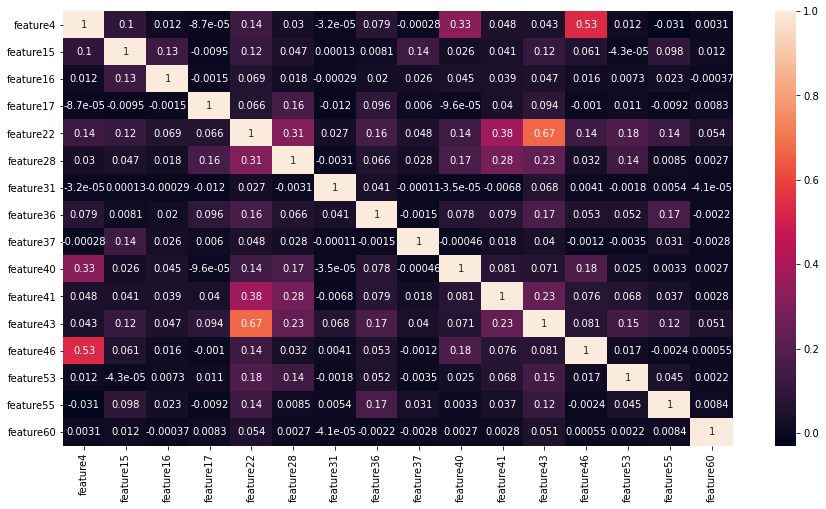

In [358]:
f , ax = plt.subplots(figsize = (15, 8))
sns.heatmap(train.loc[:,new_col].corr(), annot = True)

In [0]:
#variable reduction
train.drop(["feature22", "account_id", "week_start_date"], axis=1,inplace= True)

# Splitting into training and testing set 

In [360]:
from sklearn.model_selection import train_test_split
X= train.drop(["Label"], axis=1)
y= train["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)
# summarize
train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X.shape

>Train: 0=22480, 1=519, Test: 0=5620, 1=130


((22999, 15), (5750, 15), (22999,), (5750,), (28749, 15))

# LOGISTIC REGRESSION WITHOUT SAMPLING

In [361]:
# Creating the hyperparameter grid 
c_space = np.logspace(-5, 8, 15) 
param_grid = {'C': c_space} 
  
# Instantiating logistic regression classifier 
LR = LogisticRegression() 
  
# Instantiating the GridSearchCV object 
LR_cv = GridSearchCV(LR, param_grid, cv = 5) 
  
LR_cv.fit(X, y) 
  
# Print the tuned parameters and score 
print("Tuned Logistic Regression Parameters: {}".format(LR_cv.best_params_))  
print("Best score is {}".format(LR_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 0.4393970560760795}
Best score is 0.981181876621265


In [362]:
LR = LogisticRegression(C= 0.4393970560760795).fit(X_train, y_train)
LR_pred  = LR.predict(X_test)

CM = confusion_matrix(y_test, LR_pred)
CM = pd.crosstab(pd.Series(y_test.values,name="Actual"), pd.Series(LR_pred,name="Predicted"))
print(CM)
print("accuracy_score:", accuracy_score(y_test, LR_pred)*100)

print("f1_score:", f1_score(y_test, LR_pred))
print("roc_auc_score:", roc_auc_score(y_test, LR_pred))
print(classification_report(y_test,LR_pred))

Predicted     0   1
Actual             
0          5605  15
1            91  39
accuracy_score: 98.15652173913043
f1_score: 0.42391304347826086
roc_auc_score: 0.6486654804270463
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5620
           1       0.72      0.30      0.42       130

    accuracy                           0.98      5750
   macro avg       0.85      0.65      0.71      5750
weighted avg       0.98      0.98      0.98      5750



# RF WITHOUT SAMPLING

In [0]:
#Hyper_parameter tunning.

n_estimators=[50, 100, 150, 200, 500]

max_features= ["auto", "sqrt", "log2"]
max_depth=[1, 20, 30, 40, 50]
max_depth.append(None)
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf=[2, 5, 1, 15]


grid_param= {'n_estimators': n_estimators,"max_features": max_features,"max_depth": max_depth,"min_samples_split": min_samples_split,"min_samples_leaf": min_samples_leaf}

RF_model = RandomForestClassifier(random_state=1)
RF_random= RandomizedSearchCV(estimator =RF_model,param_distributions=grid_param, n_iter =100,cv= 5, verbose= 2, random_state=42,n_jobs=-1)
# Fit the grid search to the data
RF_random.fit(X_train, y_train)
print(RF_random.best_params_)

In [364]:
RF_model = RandomForestClassifier(n_estimators = 100,max_depth=20,min_samples_split=10,min_samples_leaf=2,max_features='sqrt').fit(X_train, y_train)
RF_pred = RF_model.predict(X_test)

CM = confusion_matrix(y_test, RF_pred)
CM = pd.crosstab(pd.Series(y_test.values,name="Actual"), pd.Series(RF_pred,name="Predicted"))
print(CM)
print("accuracy_score:", accuracy_score(y_test, RF_pred)*100)

print("f1_score:", f1_score(y_test, RF_pred))
print("roc_auc_score:", roc_auc_score(y_test, RF_pred))
print(classification_report(y_test,RF_pred))

Predicted     0   1
Actual             
0          5603  17
1            88  42
accuracy_score: 98.17391304347825
f1_score: 0.4444444444444444
roc_auc_score: 0.6600260060224472
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5620
           1       0.71      0.32      0.44       130

    accuracy                           0.98      5750
   macro avg       0.85      0.66      0.72      5750
weighted avg       0.98      0.98      0.98      5750



# XGBOOST WITHOUT SAMPLING

In [365]:
XGB = XGBClassifier(max_depth=4, learning_rate=0.2, n_estimators=200, min_child_weight=1, random_state=18) 
XGB.fit(X_train, y_train) 
XGB_pred = XGB.predict(X_test) 
CM = confusion_matrix(y_test, XGB_pred)
CM = pd.crosstab(pd.Series(y_test.values,name="Actual"), pd.Series(XGB_pred,name="Predicted"))
print(CM)
print("accuracy_score:", accuracy_score(y_test, XGB_pred)*100)

print("f1_score:", f1_score(y_test, XGB_pred))
print("roc_auc_score:", roc_auc_score(y_test, XGB_pred))
print(classification_report(y_test,XGB_pred))

Predicted     0   1
Actual             
0          5603  17
1            83  47
accuracy_score: 98.26086956521739
f1_score: 0.48453608247422675
roc_auc_score: 0.6792567752532166
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5620
           1       0.73      0.36      0.48       130

    accuracy                           0.98      5750
   macro avg       0.86      0.68      0.74      5750
weighted avg       0.98      0.98      0.98      5750



# DOWN SAMPLING 

In [366]:
minority_class_len = len(train[train["Label"] == 1])
majority_class_indices = train[train["Label"]== 0].index

random_majority_indices = np.random.choice(majority_class_indices, minority_class_len, replace = False)
minority_class_indices = train[train["Label"]== 1].index
print(minority_class_indices)
under_sample_indices = np.concatenate([minority_class_indices, random_majority_indices])
under_sample = train.loc[under_sample_indices]

Int64Index([  102,   104,   243,   245,   387,   389,   528,   530,   631,
              633,
            ...
            34994, 53833, 53834, 67947, 67948, 70631, 71112, 71113, 71127,
            71128],
           dtype='int64', length=649)


In [367]:
under_sample["Label"].value_counts()

1    649
0    649
Name: Label, dtype: int64

In [368]:
X= under_sample.drop(["Label"], axis=1)
y= under_sample["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=36, stratify=y)
# summarize
train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

>Train: 0=519, 1=519, Test: 0=130, 1=130


# LOGISTIC REGRESSION DOWNSAMPLING

In [369]:
LR_DS = LogisticRegression().fit(X_train, y_train)
LR_DS_pred  = LR_DS.predict(X_test)

CM = confusion_matrix(y_test, LR_DS_pred)
CM = pd.crosstab(pd.Series(y_test.values,name="Actual"), pd.Series(LR_DS_pred,name="Predicted"))
print(CM)
print("accuracy_score:", accuracy_score(y_test, LR_DS_pred)*100)

print("f1_score:", f1_score(y_test, LR_DS_pred))
print("roc_auc_score:", roc_auc_score(y_test, LR_DS_pred))
print(classification_report(y_test,LR_DS_pred))

Predicted    0   1
Actual            
0          130   0
1           77  53
accuracy_score: 70.38461538461539
f1_score: 0.5792349726775957
roc_auc_score: 0.7038461538461538
              precision    recall  f1-score   support

           0       0.63      1.00      0.77       130
           1       1.00      0.41      0.58       130

    accuracy                           0.70       260
   macro avg       0.81      0.70      0.68       260
weighted avg       0.81      0.70      0.68       260



# RANDOM FOREST DOWNSMPLING

In [370]:
RF_DS = RandomForestClassifier(n_estimators = 500,max_depth=30,min_samples_split=10,min_samples_leaf=1,max_features='log2').fit(X_train, y_train)
RF_DS_pred = RF_DS.predict(X_test)

CM = confusion_matrix(y_test, RF_DS_pred)
CM = pd.crosstab(pd.Series(y_test.values,name="Actual"), pd.Series(RF_DS_pred,name="Predicted"))
print(CM)
print("accuracy_score:", accuracy_score(y_test, RF_DS_pred)*100)

print("f1_score:", f1_score(y_test, RF_DS_pred))
print("roc_auc_score:", roc_auc_score(y_test, RF_DS_pred))
print(classification_report(y_test,RF_DS_pred))

Predicted    0   1
Actual            
0          120  10
1           48  82
accuracy_score: 77.6923076923077
f1_score: 0.7387387387387386
roc_auc_score: 0.7769230769230769
              precision    recall  f1-score   support

           0       0.71      0.92      0.81       130
           1       0.89      0.63      0.74       130

    accuracy                           0.78       260
   macro avg       0.80      0.78      0.77       260
weighted avg       0.80      0.78      0.77       260



# XGBOOST DOWNSAMPLING

In [371]:
XGB_DS = XGBClassifier()  
XGB_DS.fit(X_train, y_train)  
XGB_DS_pred = XGB_DS.predict(X_test)  
CM = confusion_matrix(y_test, XGB_DS_pred) 
CM = pd.crosstab(pd.Series(y_test.values,name="Actual"), pd.Series(XGB_DS_pred,name="Predicted")) 
print(CM) 
print("accuracy_score:", accuracy_score(y_test, XGB_DS_pred)*100) 
print("f1_score:", f1_score(y_test, XGB_DS_pred)) 
print("roc_auc_score:", roc_auc_score(y_test, XGB_DS_pred)) 
print(classification_report(y_test,XGB_DS_pred)) 

 

Predicted    0   1
Actual            
0          123   7
1           54  76
accuracy_score: 76.53846153846153
f1_score: 0.7136150234741784
roc_auc_score: 0.7653846153846154
              precision    recall  f1-score   support

           0       0.69      0.95      0.80       130
           1       0.92      0.58      0.71       130

    accuracy                           0.77       260
   macro avg       0.81      0.77      0.76       260
weighted avg       0.81      0.77      0.76       260



# UP SAMPLING USING SMOTE

In [372]:
X= train.drop(["Label"], axis=1)
y= train["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3, stratify=y)
# summarize
train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

>Train: 0=21074, 1=487, Test: 0=7026, 1=162


In [373]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
# import SMOTE module from imblearn library 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 

Before OverSampling, counts of label '1': 487
Before OverSampling, counts of label '0': 21074 

After OverSampling, the shape of train_X: (42148, 15)
After OverSampling, the shape of train_y: (42148,) 

After OverSampling, counts of label '1': 21074
After OverSampling, counts of label '0': 21074


# LR UPSAMPLING

In [374]:
LR_UP = LogisticRegression().fit(X_train_res, y_train_res)
LR_UP_pred  = LR_UP.predict(X_test)

CM = confusion_matrix(y_test, LR_UP_pred)
CM = pd.crosstab(pd.Series(y_test.values,name="Actual"), pd.Series(LR_UP_pred,name="Predicted"))
print(CM)
print("accuracy_score:", accuracy_score(y_test, LR_UP_pred)*100)

print("f1_score:", f1_score(y_test, LR_UP_pred))
print("roc_auc_score:", roc_auc_score(y_test, LR_UP_pred))
print(classification_report(y_test,LR_UP_pred))

Predicted     0   1
Actual             
0          6941  85
1            91  71
accuracy_score: 97.55147468002225
f1_score: 0.44654088050314467
roc_auc_score: 0.7130868414671432
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7026
           1       0.46      0.44      0.45       162

    accuracy                           0.98      7188
   macro avg       0.72      0.71      0.72      7188
weighted avg       0.98      0.98      0.98      7188



# RF UPSAMPLING

In [375]:
RF_UP_model = RandomForestClassifier(n_estimators = 500,max_depth=30,min_samples_split=10,min_samples_leaf=1,max_features='log2').fit(X_train_res, y_train_res)
RF_UP_pred = RF_UP_model.predict(X_test)

CM = confusion_matrix(y_test, RF_UP_pred)
CM = pd.crosstab(pd.Series(y_test.values,name="Actual"), pd.Series(RF_UP_pred,name="Predicted"))
print(CM)
print("accuracy_score:", accuracy_score(y_test, RF_UP_pred)*100)

print("f1_score:", f1_score(y_test, RF_UP_pred))
print("roc_auc_score:", roc_auc_score(y_test, RF_UP_pred))
print(classification_report(y_test,RF_UP_pred))

Predicted     0    1
Actual              
0          6863  163
1            86   76
accuracy_score: 96.53589315525876
f1_score: 0.3790523690773067
roc_auc_score: 0.7229681289601585
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7026
           1       0.32      0.47      0.38       162

    accuracy                           0.97      7188
   macro avg       0.65      0.72      0.68      7188
weighted avg       0.97      0.97      0.97      7188



# Predict on test dataset by using XGBOOST(without sampling training method) beacause it has better precision and recall score.


In [0]:
df_test= test.copy()

In [0]:
col = train.columns

In [379]:
df_test= df_test[col]
df_test.drop(["Label"], axis=1, inplace= True)
Label= test["Label"]
df_test.head()

,feature4,feature15,feature16,feature17,feature28,feature31,feature36,feature37,feature40,feature41,feature43,feature46,feature53,feature55,feature60
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [382]:
XGB_pred  = XGB.predict(df_test)
CM = confusion_matrix(Label, XGB_pred)
CM = pd.crosstab(pd.Series(Label.values,name="Actual"), pd.Series(XGB_pred,name="Predicted"))
print(CM)
print("accuracy_score:", accuracy_score(Label, XGB_pred)*100)

print("f1_score:", f1_score(Label, XGB_pred))
print("roc_auc_score:", roc_auc_score(Label, XGB_pred))
print(classification_report(Label, XGB_pred))

Predicted      0    1
Actual               
0          29306   37
1            166  111
accuracy_score: 99.31465226198515
f1_score: 0.5223529411764706
roc_auc_score: 0.6997305367819998
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29343
           1       0.75      0.40      0.52       277

    accuracy                           0.99     29620
   macro avg       0.87      0.70      0.76     29620
weighted avg       0.99      0.99      0.99     29620



0.8493546576154978


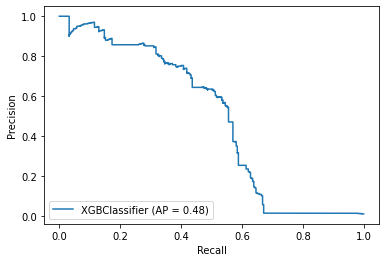

In [383]:
y_pred_proba = XGB.predict_proba(df_test)
print(roc_auc_score(Label, y_pred_proba[:,1]))
plot_precision_recall_curve(XGB,df_test,Label)

In [0]:
Final_label= pd.DataFrame(data= XGB_pred, columns= ["predicted_label"])

In [0]:
final_output= pd.concat([test["account_id"],Final_label["predicted_label"]], axis=1)

In [394]:
final_output

,account_id,predicted_label
0,105049,0
1,105049,0
2,105049,0
3,105049,0
4,105049,0
...,...,...
29615,109139,0
29616,187328,0
29617,101111,0
29618,101532,0


In [0]:
from google.colab import files
final_output.to_csv('final_output.csv') 